In [2]:
import torch
import data_s2s
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from r3m import load_r3m
r3m = load_r3m('resnet50').to('cuda:0')
r3m.eval()

/home/ademi_adeniji/anaconda3/envs/r3m_base/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ademi_adeniji/anaconda3/envs/r3m_base/lib/python3.9/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTrain

DataParallel(
  (module): R3M(
    (cs): CosineSimilarity()
    (bce): BCELoss()
    (sigm): Sigmoid()
    (convnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1

In [3]:
def show_images(batch: torch.Tensor, size=None):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(torch.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    images = Image.fromarray(reshaped.numpy())
    if size is not None:
        images = images.resize(size, Image.NEAREST)
    display(images)

def show_images_s2s(batch: torch.Tensor, **kwargs):
    """ Display a batch of images inline. """
    if batch.ndim == 3:
        batch = batch.unsqueeze(0)
    show_images(batch * 2, **kwargs)  # [-.5, .5] to [-1, 1]

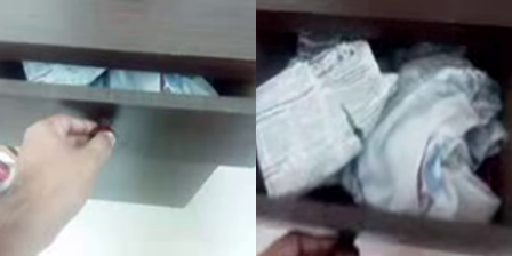

(tensor(3.7782, device='cuda:0', grad_fn=<SqueezeBackward0>), {})

In [4]:
data_idx = 0
video_dataset = data_s2s.VideoDataset(
    data_folder="/shared/ademi_adeniji/something-something/drawers/",
    sequence_length=16,
    train=True,
    resolution=224,
    frame_mode="final"
)
show_images_s2s(torch.stack(video_dataset[data_idx][:2]), size=(512, 256))
start = video_dataset[data_idx][0].to("cuda:0").unsqueeze(0)
end = video_dataset[data_idx][1].to("cuda:0").unsqueeze(0)
start = (start + 0.5) * 255
end = (end + 0.5) * 255
start = r3m(start)
end = r3m(end)
lang = np.array(["open the cabinet"])
r3m.module.get_reward(start, end, lang)

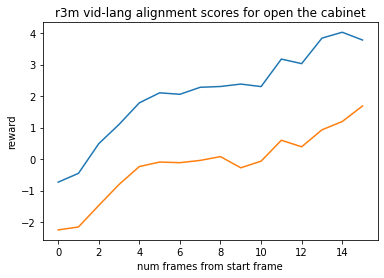

In [5]:
video_dataset = data_s2s.VideoDataset(
    data_folder="/shared/ademi_adeniji/something-something/drawers/",
    sequence_length=16,
    train=True,
    resolution=224,
    frame_mode="video"
)
video = video_dataset[data_idx][0].to("cuda:0").unsqueeze(0)
start = video[:, :, 0, :, :]
start = (start + 0.5) * 255
start = r3m(start)
lang = np.array(["open the cabinet"])
rewards = []
for i in range(16):
    end = video[:, :, i, :, :]
    end = (end + 0.5) * 255
    end = r3m(end)
    rewards.append(r3m.module.get_reward(start, end, lang)[0].cpu().detach())
plt.plot(rewards)
plt.xlabel("num frames from start frame")
plt.ylabel("reward")
plt.title("r3m vid-lang alignment scores for " + lang[0])

lang = np.array(["open the drawer"])
rewards = []
for i in range(16):
    end = video[:, :, i, :, :]
    end = (end + 0.5) * 255
    end = r3m(end)
    rewards.append(r3m.module.get_reward(start, end, lang)[0].cpu().detach())
plt.plot(rewards)

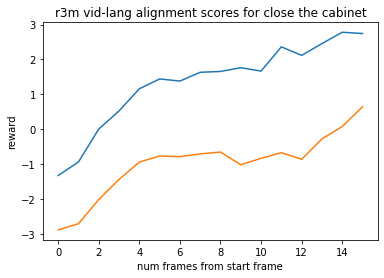

In [6]:
lang = np.array(["close the cabinet"])
rewards = []
for i in range(16):
    end = video[:, :, i, :, :]
    end = (end + 0.5) * 255
    end = r3m(end)
    rewards.append(r3m.module.get_reward(start, end, lang)[0].cpu().detach())
plt.plot(rewards)
plt.xlabel("num frames from start frame")
plt.ylabel("reward")
plt.title("r3m vid-lang alignment scores for " + lang[0])

lang = np.array(["close the drawer"])
rewards = []
for i in range(16):
    end = video[:, :, i, :, :]
    end = (end + 0.5) * 255
    end = r3m(end)
    rewards.append(r3m.module.get_reward(start, end, lang)[0].cpu().detach())
plt.plot(rewards)

Text(0.5, 1.0, 'r3m vid-lang alignment scores for close the toaster')

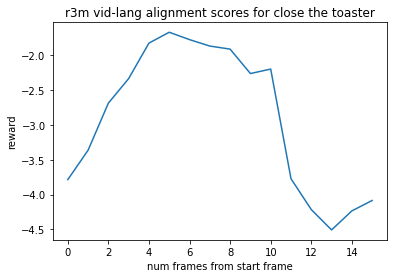

In [7]:
lang = np.array(["close the toaster"])
rewards = []
for i in range(16):
    end = video[:, :, i, :, :]
    end = (end + 0.5) * 255
    end = r3m(end)
    rewards.append(r3m.module.get_reward(start, end, lang)[0].cpu().detach())
plt.plot(rewards)
plt.xlabel("num frames from start frame")
plt.ylabel("reward")
plt.title("r3m vid-lang alignment scores for " + lang[0])

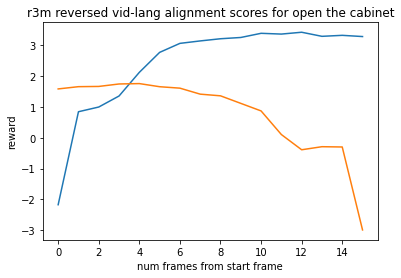

In [8]:
video_dataset = data_s2s.VideoDataset(
    data_folder="/shared/ademi_adeniji/something-something/drawers/",
    sequence_length=16,
    train=True,
    resolution=224,
    frame_mode="video"
)
start = video[:, :, -1, :, :]
start = (start + 0.5) * 255
start = r3m(start)
lang = np.array(["open the cabinet"])
rewards = []
for i in range(16):
    end = video[:, :, 15-i, :, :]
    end = (end + 0.5) * 255
    end = r3m(end)
    rewards.append(r3m.module.get_reward(start, end, lang)[0].cpu().detach())
plt.plot(rewards)
plt.xlabel("num frames from start frame")
plt.ylabel("reward")
plt.title("r3m reversed vid-lang alignment scores for " + lang[0])

lang = np.array(["open the drawer"])
rewards = []
for i in range(16):
    end = video[:, :, i, :, :]
    end = (end + 0.5) * 255
    end = r3m(end)
    rewards.append(r3m.module.get_reward(start, end, lang)[0].cpu().detach())
plt.plot(rewards)

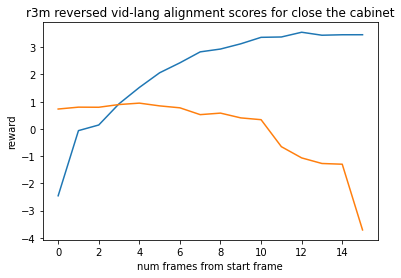

In [9]:
video_dataset = data_s2s.VideoDataset(
    data_folder="/shared/ademi_adeniji/something-something/drawers/",
    sequence_length=16,
    train=True,
    resolution=224,
    frame_mode="video"
)
start = video[:, :, -1, :, :]
start = (start + 0.5) * 255
start = r3m(start)
lang = np.array(["close the cabinet"])
rewards = []
for i in range(16):
    end = video[:, :, 15-i, :, :]
    end = (end + 0.5) * 255
    end = r3m(end)
    rewards.append(r3m.module.get_reward(start, end, lang)[0].cpu().detach())
plt.plot(rewards)
plt.xlabel("num frames from start frame")
plt.ylabel("reward")
plt.title("r3m reversed vid-lang alignment scores for " + lang[0])

lang = np.array(["close the drawer"])
rewards = []
for i in range(16):
    end = video[:, :, i, :, :]
    end = (end + 0.5) * 255
    end = r3m(end)
    rewards.append(r3m.module.get_reward(start, end, lang)[0].cpu().detach())
plt.plot(rewards)

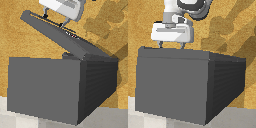

Text(0.5, 1.0, 'r3m vid-lang alignment scores for close the fridge')

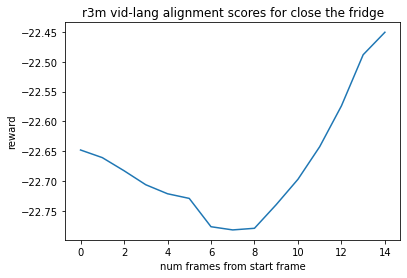

In [30]:
import numpy as np
from PIL import Image, ImageSequence

img = Image.open('CloseFridge-right_shoulder_rgb.gif')
frames = np.array([np.array(frame.copy().convert('RGB').getdata(),dtype=np.uint8).reshape(frame.size[1],frame.size[0],3) for frame in ImageSequence.Iterator(img)])
close_fridge = (((torch.as_tensor(frames) / 255.0) * 2) - 1).permute((0, 3, 2, 1))
close_fridge_display = torch.stack((close_fridge[80], close_fridge[-1])) 
show_images(close_fridge_display)

start = close_fridge[80].unsqueeze(0)
start = r3m(start)
lang = np.array(["close the fridge"])
rewards = []
for i in range(15):
    end = close_fridge[80+i].unsqueeze(0)
    end = r3m(end)
    rewards.append(r3m.module.get_reward(start, end, lang)[0].cpu().detach())
plt.plot(rewards)
plt.xlabel("num frames from start frame")
plt.ylabel("reward")
plt.title("r3m vid-lang alignment scores for " + lang[0])

# lang = np.array(["close the box"])
# rewards = []
# for i in range(15):
#     end = close_fridge[80+i].unsqueeze(0)
#     end = r3m(end)
#     rewards.append(r3m.module.get_reward(start, end, lang)[0].cpu().detach())
# plt.plot(rewards)

Text(0.5, 1.0, 'r3m vid-lang alignment scores for open the fridge')

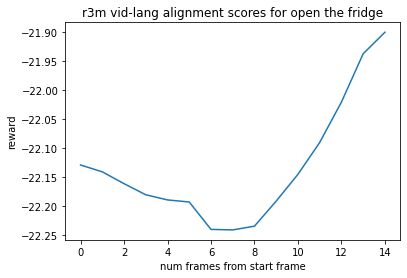

In [31]:
start = close_fridge[-1].unsqueeze(0)
start = r3m(start)
lang = np.array(["open the fridge"])
rewards = []
for i in range(15):
    end = close_fridge[80+i].unsqueeze(0)
    end = r3m(end)
    rewards.append(r3m.module.get_reward(start, end, lang)[0].cpu().detach())
plt.plot(rewards)
plt.xlabel("num frames from start frame")
plt.ylabel("reward")
plt.title("r3m vid-lang alignment scores for " + lang[0])

Text(0.5, 1.0, 'r3m vid-lang alignment scores for close the pot')

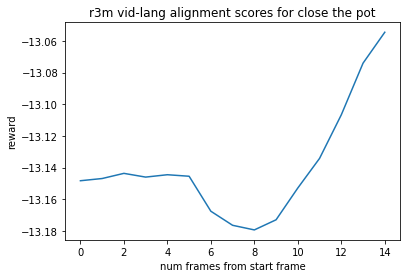

In [32]:
start = close_fridge[-1].unsqueeze(0)
start = r3m(start)
lang = np.array(["close the pot"])
rewards = []
for i in range(15):
    end = close_fridge[80+i].unsqueeze(0)
    end = r3m(end)
    rewards.append(r3m.module.get_reward(start, end, lang)[0].cpu().detach())
plt.plot(rewards)
plt.xlabel("num frames from start frame")
plt.ylabel("reward")
plt.title("r3m vid-lang alignment scores for " + lang[0])

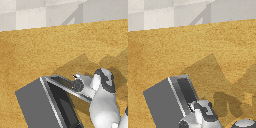

torch.Size([99, 3, 128, 128])


Text(0.5, 1.0, 'r3m vid-lang alignment scores for close the microwave')

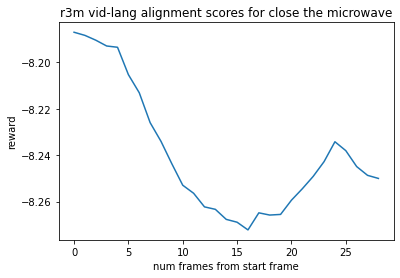

In [33]:
img = Image.open('CloseMicrowave-left_shoulder_rgb.gif')
frames = np.array([np.array(frame.copy().convert('RGB').getdata(),dtype=np.uint8).reshape(frame.size[1],frame.size[0],3) for frame in ImageSequence.Iterator(img)])
close_fridge = (((torch.as_tensor(frames) / 255.0) * 2) - 1).permute((0, 3, 2, 1))
close_fridge_display = torch.stack((close_fridge[70], close_fridge[-1])) 
show_images(close_fridge_display)
print(close_fridge.shape)
start = close_fridge[70].unsqueeze(0)
start = r3m(start)
lang = np.array(["close the microwave"])
rewards = []
for i in range(29):
    end = close_fridge[70+i].unsqueeze(0)
    end = r3m(end)
    rewards.append(r3m.module.get_reward(start, end, lang)[0].cpu().detach())
plt.plot(rewards)
plt.xlabel("num frames from start frame")
plt.ylabel("reward")
plt.title("r3m vid-lang alignment scores for " + lang[0])


Text(0.5, 1.0, 'r3m vid-lang alignment scores for open the microwave')

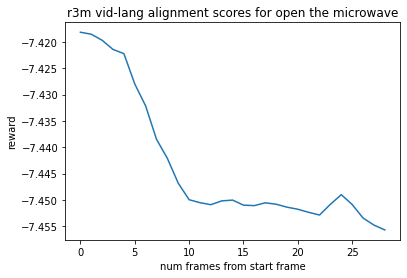

In [34]:
start = close_fridge[-1].unsqueeze(0)
start = r3m(start)
lang = np.array(["open the microwave"])
rewards = []
for i in range(29):
    end = close_fridge[70+i].unsqueeze(0)
    end = r3m(end)
    rewards.append(r3m.module.get_reward(start, end, lang)[0].cpu().detach())
plt.plot(rewards)
plt.xlabel("num frames from start frame")
plt.ylabel("reward")
plt.title("r3m vid-lang alignment scores for " + lang[0])

Text(0.5, 1.0, 'r3m vid-lang alignment scores for close the pot')

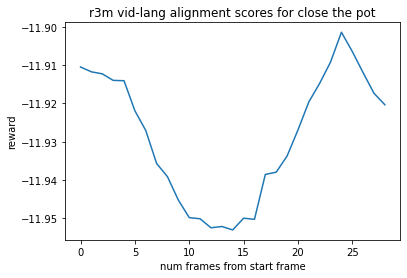

In [35]:
start = close_fridge[-1].unsqueeze(0)
start = r3m(start)
lang = np.array(["close the pot"])
rewards = []
for i in range(29):
    end = close_fridge[70+i].unsqueeze(0)
    end = r3m(end)
    rewards.append(r3m.module.get_reward(start, end, lang)[0].cpu().detach())
plt.plot(rewards)
plt.xlabel("num frames from start frame")
plt.ylabel("reward")
plt.title("r3m vid-lang alignment scores for " + lang[0])